# CSI 5139 Convolutional Neural Network in Computer Vision Assignment III
## Name: Zishen Chen
## Student Number: 300189498            
## Email: zchen314@uottawa.ca

In [1]:
import numpy as np
from skimage.color import rgb2gray
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix,accuracy_score
import tensorflow.keras.backend as K
import tensorflow as tf
import os
from skimage.io import imread
from skimage.util import crop
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D,  MaxPool2D,  Flatten, Dense
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split
from skimage.transform import resize

img_path='./Synthetic_Leopard_Circle/'
FAL=-1000
box = ((196,120), (154, 180),(0,0))# The cropping box.
commom_size=(100, 160, 3)#Common size of image after cropping and resize.

### The function of getting offset.

In [2]:
def getOffset(img1,img2):
    '''
    Get offset of two given images

    :return: The degree of offset within the range (-45,45).
    '''
    dg1=int(img1.split('_')[1].split('.')[0])*3
    dg2=int(img2.split('_')[1].split('.')[0])*3
    fs=dg2-dg1
    if fs >= -45 and fs <= 45:
        return fs
    elif 360-abs(fs) >= -45 and 360-abs(fs) <= 45:
        if fs >0:
            return 360-abs(fs)
        else :
            return -1*(360-abs(fs))
    return FAL

### The function of getting image data.

In [3]:
def loadData( path ):
    '''
    The function gets images according to given path and find out all possible images pairs in it and construct them
    as following form: x:(image1,image2) : y{label:(1,0)}. Meanwhile, every pixels in the images are divided by 255 in
    order to normalize

    :param Path: A str. The path of data
    :return: Two np.narray object. Images pairs and labels mention above with shape(n, 2, 64, 64) and (n, )
    '''
    print('Loading data....')
    imageList=os.listdir(path)
    x=[]
    y=[]
    for i in range(120):
        img1 = imread(path + imageList[i])
        for j in range(120):
            #Get the offset of pairs
            offset=getOffset(imageList[i], imageList[j])
            #Skip if the offset is not in the range(-45,45)
            if offset == FAL:
                continue
            img2=imread(path + imageList[j])
            x.append([img1,img2])
            #The ground true will be positive values (0,30) where value 0 denotes degree -15
            y.append(offset/3+15)
    x=np.array(x)
    y=np.array(y)
    return x,y

### The function doing any necessary pre-processing steps. The images'shape after preprocessing will become (164, 306）.

In [4]:
def prePrec(data_x, data_y,gray=False ,parallel=False):
    '''
    This function can do pre-processing to the given dataset according to specific requirement like croping, resize, concatenating and so on. 
    And this function will split the original dataset into training set validation set, test set in a ratio of 90:10:20.

    :param data_x: Image pairs in shape(n,2,648,480)
    :param data_y: The ground truth
    :param gray: A boolean value indicates if the images need to be convert to gray image
    :param parallel: A boolean value indicates the dataset need to be applied in a parallel network or not.(for the final task)
    :return: Training set validation set and test set
    '''
    print('Pre-precessing....')
    x=[]
    for pairs in data_x:
        #Cropping, resizing and normalization(0,1).
        if gray == True:
            sup=np.ones((commom_size[0],commom_size[1],1),dtype=np.float32)
            x.append(np.concatenate((resize((crop(rgb2gray(pairs[0]), (box[0],box[1])).astype(np.float32)-255./2) / (255./2), (commom_size[0],commom_size[1],1)),
                                     resize((crop(rgb2gray(pairs[1]), (box[0],box[1])).astype(np.float32)-255./2) / (255./2), (commom_size[0],commom_size[1],1)),sup), axis=2))
        # The pixels of images will be normalized in (-1,1) if the pretrained CNN is Mobile-V2.
        elif parallel == True:
            x.append([ resize((crop(pairs[0],box).astype(np.float32)-255./2) / (255./2),  commom_size),  resize((crop(pairs[1],box).astype(np.float32)-255./2) / (255./2), commom_size)])
        else:
            x.append(np.concatenate((resize(crop(pairs[0],box).astype(np.float32)/255.,commom_size) , resize(crop(pairs[1],box).astype(np.float32)/255., commom_size)),axis=2))
    x=np.array(x)

    #Split dataset in a ratio (90:10:20)
    x_train, x_test, y_train, y_test = train_test_split(x, data_y, test_size=2./12., shuffle=True)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1./10., shuffle=True)
    #Transpose the shape of array if the dataset is used to train in a parallel structure.
    if parallel == True:
        x_train=np.transpose(x_train, (1, 0, 2, 3, 4))
        x_val = np.transpose(x_val, (1, 0, 2, 3, 4))
        x_test = np.transpose(x_test, (1, 0, 2, 3, 4))
    return x_train,y_train,x_val,y_val,x_test,y_test


### The architecture of CNN.

In [5]:
class Net(Model):
    def __init__(self, type):
        super(Net, self).__init__()
        self.c1 = Conv2D(filters=6, kernel_size=(5, 5), activation='relu',padding='same')
        self.p1 = MaxPool2D(pool_size=(2, 2), strides=2)

        self.c2 = Conv2D(filters=16, kernel_size=(5, 5), activation='relu',padding='same')
        self.p2 = MaxPool2D(pool_size=(2, 2), strides=2)

        self.flatten = Flatten()
        self.f1 = Dense(120, activation='relu')
        self.f2 = Dense(84, activation='relu')

        if type == 'classification':
            self.f3 = Dense(31, activation='softmax')
        else:
            self.f3 = Dense(1,activation='tanh')

    def call(self, x):
        x = self.c1(x)
        x = self.p1(x)

        x = self.c2(x)
        x = self.p2(x)

        x = self.flatten(x)
        x = self.f1(x)
        x = self.f2(x)
        y = self.f3(x)
        return y
def getPre(data):
    y=[]
    for i in range(len(data)):
        flag=-1
        index=-1
        for j in range(len(data[i])):
            index=j if data[i][j]>flag else index
            flag=max(flag,data[i][j])
        y.append(index)
    return np.array(y)

### Training process will be done in this function. The learning curves of the model will also be plotted.

In [6]:
def train(model,train_x,train_y,valid_x,valid_y,parameters,continue_from=0):
    '''
    This function to run training process according to given model and data. In this case, the optimizer of training is Adam
    and use a binary crossentropy or mse as loss function.

    :param model: The model need to be trained
    :param train_x: Training image pairs with shape (n, 2, 64, 64)
    :param train_y: Training labels list
    :param valid_x: Validation dataset split beforehand
    :param valid_y: Validation labels
    :param parameters: A dictionary that record hyper-parameters of different training task.
    :param continue_from: An integer used for continue training
    :return: A trained model object and its learning history.
    '''
    print('Training....')
    #If the dataset is used for regression problem, and the ground true will be set (-1,1)
    if parameters['type'] == 'regression'or parameters['type'] == 'parallel':
        train_y=(train_y-15)/15.
        valid_y=(valid_y-15)/15.
    adam = tf.keras.optimizers.Adam( lr=parameters['lr'],clipnorm=1)
    model.compile(optimizer=adam,
                  loss=parameters['loss'],
                  metrics=parameters['metrics'])
    history=None
    if os.path.exists(parameters['save_path'] + '.index'):
        print('-------------load the model-----------------')
        model.load_weights(parameters['save_path'])
    else:
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=parameters['save_path'],save_weights_only=True,save_best_only=True)
        if parameters['type'] == 'parallel':
            train_x=[train_x[0],train_x[1]]
            valid_x=[valid_x[0],valid_x[1]]
        history = model.fit(train_x, train_y, batch_size=parameters['batch_size'], initial_epoch=continue_from,epochs=parameters['epoch'], validation_data=(valid_x, valid_y),validation_freq=1 ,callbacks=[cp_callback],shuffle=True)
        acc = history.history[parameters['metrics'][0]]
        val_acc = history.history['val_' + parameters['metrics'][0]]
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        plt.subplot(1, 2, 1)
        plt.plot(acc, label='Training '+parameters['metrics'][0])
        plt.plot(val_acc, label='Validation '+parameters['metrics'][0])
        plt.title('Training and Validation '+parameters['metrics'][0])
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()
    return model,history

### Hyper-parameter set according to different training tasks.

In [7]:
parameter_set={
    'classification':{
        'type':'classification',
        'epoch':200,
        'batch_size':32,
        'lr':0.001,
        'loss':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        'metrics':['sparse_categorical_accuracy'],
        'save_path':'./checkpoint/leopard_classification.ckpt'
    },
    'regression':{
        'type':'regression',
        'epoch': 50,
        'batch_size': 32,
        'lr': 0.0001,
        'loss': tf.keras.losses.mean_squared_error,
        'metrics': ['mse'],
        'save_path':'./checkpoint/leopard_regression.ckpt'
    },
    'mobilenet-v2_regression':{
        'type': 'regression',
        'epoch': 600,
        'batch_size': 16,
        'lr': 0.0001,
        'loss': tf.keras.losses.mean_squared_error,
        'metrics': ['mse'],
        'save_path': './checkpoint/leopard_mobilenet-v2_regression.ckpt'
    },
    'mobilenet-v2_parallel':{
        'type': 'parallel',
        'epoch': 20,
        'batch_size': 16,
        'lr': 0.0001,
        'loss': tf.keras.losses.mean_squared_error,
        'metrics': ['mse'],
        'save_path': './checkpoint/leopard_mobilenet-v2_parallel.ckpt'
    },
    'momobilenet-v2_finetune':{
        'type': 'parallel',
        'epoch': 60,
        'batch_size': 16,
        'lr': 0.0001,
        'loss': tf.keras.losses.mean_squared_error,
        'metrics': ['mse'],
        'save_path': './checkpoint/leopard_mobilenet-v2_finetune.ckpt'

    }

}

## Task1: Classification Network
### In this case, the ground truth value is ranging from 0 to 31 denotes degree (-45,45) and I take 200 epoch with 32 batch size. The learning rate will be 0.001 and loss function is crossentropy loss. The acc on both validation set and test set are greater than 90% after 200 epoch.


In [8]:
data_x,data_y=loadData(img_path)

Loading data....


In [9]:
x_train, y_train, x_val, y_val, x_test, y_test = prePrec(data_x,data_y)

Pre-precessing....


Pre-precessing....
Training....
Epoch 1/200
88/88 [==============================] - 2s 28ms/step - loss: 3.4345 - sparse_categorical_accuracy: 0.0513 - val_loss: 3.1708 - val_sparse_categorical_accuracy: 0.0774
Epoch 2/200
88/88 [==============================] - 2s 23ms/step - loss: 2.7155 - sparse_categorical_accuracy: 0.1416 - val_loss: 2.2674 - val_sparse_categorical_accuracy: 0.2194
Epoch 3/200
88/88 [==============================] - 2s 23ms/step - loss: 2.0480 - sparse_categorical_accuracy: 0.2663 - val_loss: 1.8834 - val_sparse_categorical_accuracy: 0.2645
Epoch 4/200
88/88 [==============================] - 2s 23ms/step - loss: 1.6510 - sparse_categorical_accuracy: 0.3563 - val_loss: 1.6875 - val_sparse_categorical_accuracy: 0.3355
Epoch 5/200
88/88 [==============================] - 2s 23ms/step - loss: 1.3931 - sparse_categorical_accuracy: 0.4315 - val_loss: 1.5119 - val_sparse_categorical_accuracy: 0.3613
Epoch 6/200
88/88 [==============================] - 2s 23ms/step - 

Epoch 46/200
88/88 [==============================] - 2s 23ms/step - loss: 0.2112 - sparse_categorical_accuracy: 0.9183 - val_loss: 0.2532 - val_sparse_categorical_accuracy: 0.9032
Epoch 47/200
88/88 [==============================] - 2s 20ms/step - loss: 0.2326 - sparse_categorical_accuracy: 0.9215 - val_loss: 0.3241 - val_sparse_categorical_accuracy: 0.8548
Epoch 48/200
88/88 [==============================] - 2s 20ms/step - loss: 0.3149 - sparse_categorical_accuracy: 0.8939 - val_loss: 0.4848 - val_sparse_categorical_accuracy: 0.8226
Epoch 49/200
88/88 [==============================] - 2s 20ms/step - loss: 0.1506 - sparse_categorical_accuracy: 0.9470 - val_loss: 0.4182 - val_sparse_categorical_accuracy: 0.8516
Epoch 50/200
88/88 [==============================] - 2s 20ms/step - loss: 0.2076 - sparse_categorical_accuracy: 0.9251 - val_loss: 0.3155 - val_sparse_categorical_accuracy: 0.8806
Epoch 51/200
88/88 [==============================] - 2s 20ms/step - loss: 0.1336 - sparse_cate

88/88 [==============================] - 2s 21ms/step - loss: 0.0616 - sparse_categorical_accuracy: 0.9832 - val_loss: 0.3342 - val_sparse_categorical_accuracy: 0.9194
Epoch 137/200
88/88 [==============================] - 2s 20ms/step - loss: 0.0667 - sparse_categorical_accuracy: 0.9832 - val_loss: 0.2828 - val_sparse_categorical_accuracy: 0.9387
Epoch 138/200
88/88 [==============================] - 2s 21ms/step - loss: 0.0520 - sparse_categorical_accuracy: 0.9849 - val_loss: 0.6143 - val_sparse_categorical_accuracy: 0.8968
Epoch 139/200
88/88 [==============================] - 2s 20ms/step - loss: 0.0360 - sparse_categorical_accuracy: 0.9878 - val_loss: 0.3290 - val_sparse_categorical_accuracy: 0.9258
Epoch 140/200
88/88 [==============================] - 2s 21ms/step - loss: 0.0834 - sparse_categorical_accuracy: 0.9774 - val_loss: 0.6129 - val_sparse_categorical_accuracy: 0.9000
Epoch 141/200
88/88 [==============================] - 2s 21ms/step - loss: 0.0864 - sparse_categorical_

Epoch 181/200
88/88 [==============================] - 2s 21ms/step - loss: 0.0355 - sparse_categorical_accuracy: 0.9896 - val_loss: 0.4386 - val_sparse_categorical_accuracy: 0.9161
Epoch 182/200
88/88 [==============================] - 2s 21ms/step - loss: 0.0664 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.2700 - val_sparse_categorical_accuracy: 0.9452
Epoch 183/200
88/88 [==============================] - 2s 21ms/step - loss: 0.0670 - sparse_categorical_accuracy: 0.9885 - val_loss: 0.3427 - val_sparse_categorical_accuracy: 0.9452
Epoch 184/200
88/88 [==============================] - 2s 21ms/step - loss: 0.1080 - sparse_categorical_accuracy: 0.9738 - val_loss: 0.4080 - val_sparse_categorical_accuracy: 0.9258
Epoch 185/200
88/88 [==============================] - 2s 21ms/step - loss: 0.1155 - sparse_categorical_accuracy: 0.9685 - val_loss: 0.4875 - val_sparse_categorical_accuracy: 0.9065
Epoch 186/200
88/88 [==============================] - 2s 21ms/step - loss: 0.0833 - spars

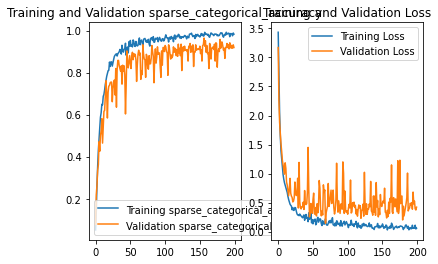

Accuracy on testset:0.9274193548387096


In [10]:

#Classification

model_clas=Net('classification')
model_clas=train(model_clas,x_train,y_train,x_val,y_val, parameters=parameter_set['classification'])[0]

print('Accuracy on testset:{}'.format(accuracy_score(y_test,getPre(model_clas.predict(x_test)))))

## Task2: Regression Network
### In this case, the ground truth value will be normalized to range from -1 to 1 and the output layer of CNN apply tanh as its activation function. Comparing with the previous task, the learning rate is set much smaller(0.0001). The mean square error will be used to evaluate the performance of model.
* The MSE on training set is pretty close to 0(1e-4) after 50, so I choose 50 epoch to train the model.
* The MSE on validation set is similar to that of training set shown in the curves and mse on test set is more smaller that that of validation set which is 0.0009.


Training....
Epoch 1/50
88/88 [==============================] - 3s 33ms/step - loss: 0.2463 - mse: 0.2463 - val_loss: 0.0957 - val_mse: 0.0957
Epoch 2/50
88/88 [==============================] - 3s 29ms/step - loss: 0.0385 - mse: 0.0385 - val_loss: 0.0242 - val_mse: 0.0242
Epoch 3/50
88/88 [==============================] - 3s 30ms/step - loss: 0.0153 - mse: 0.0153 - val_loss: 0.0144 - val_mse: 0.0144
Epoch 4/50
88/88 [==============================] - 2s 28ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 5/50
88/88 [==============================] - 2s 24ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 6/50
88/88 [==============================] - 3s 28ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 7/50
88/88 [==============================] - 2s 28ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 8/50
88/88 [==============================] - 2s 23ms/step - los

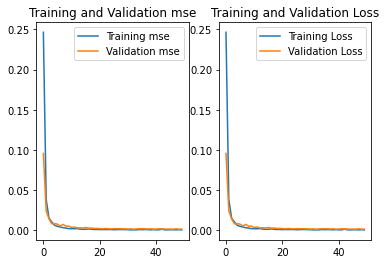

MSE on testset:0.0009665620164014399


In [10]:
model_reg=Net('regression')
model_reg=train(model_reg, x_train, y_train, x_val, y_val, parameters=parameter_set['regression'])[0]
mse = tf.keras.losses.MeanSquaredError()
loss = mse((y_test-15)/15.,model_reg.predict(x_test).reshape(-1,))
print('MSE on testset:{}'.format(loss))


## Task3: MobileNet V2
### I use pretrained MobileNet-V2 with parameters frozen, and add a head contains a conv layer, a max pooling layer and a output layer with tanh activation function to Mobile-Net-V2 as a new CNN model. The image will be transform to gray image and stack together.  
* Because there are limited trainable parameters, I choose a smaller batch size(16) and run 600 epoch. 
* However, this model seems difficult to converge. The training MSE is approximatly 0.09 after 600 epoch while the validation MSE is much unstable and bouncing from 0.05 to 0.2 shown in the curves. Testing MSE is about 0.22 in the end.
* I think the reasen might be in this case we just use the gray stacked input image which doesn't has enough features than previous task and the limited trainable parameters, the solution is that we can apply learning rate decay strategy and take more epoch. 

Pre-precessing....
Training....
Epoch 1/600
175/175 [==============================] - 5s 27ms/step - loss: 0.4360 - mse: 0.4360 - val_loss: 0.3946 - val_mse: 0.3946
Epoch 2/600
175/175 [==============================] - 4s 23ms/step - loss: 0.4002 - mse: 0.4002 - val_loss: 0.4169 - val_mse: 0.4169
Epoch 3/600
175/175 [==============================] - 4s 24ms/step - loss: 0.4001 - mse: 0.4001 - val_loss: 0.3323 - val_mse: 0.3323
Epoch 4/600
175/175 [==============================] - 4s 24ms/step - loss: 0.4287 - mse: 0.4287 - val_loss: 0.3234 - val_mse: 0.3234
Epoch 5/600
175/175 [==============================] - 4s 24ms/step - loss: 0.3929 - mse: 0.3929 - val_loss: 0.3180 - val_mse: 0.3180
Epoch 6/600
175/175 [==============================] - 4s 23ms/step - loss: 0.3919 - mse: 0.3919 - val_loss: 0.3643 - val_mse: 0.3643
Epoch 7/600
175/175 [==============================] - 4s 24ms/step - loss: 0.3877 - mse: 0.3877 - val_loss: 0.3079 - val_mse: 0.3079
Epoch 8/600
175/175 [=========

175/175 [==============================] - 4s 23ms/step - loss: 0.2692 - mse: 0.2692 - val_loss: 0.2331 - val_mse: 0.2331
Epoch 121/600
175/175 [==============================] - 4s 23ms/step - loss: 0.2538 - mse: 0.2538 - val_loss: 0.3105 - val_mse: 0.3105
Epoch 122/600
175/175 [==============================] - 4s 23ms/step - loss: 0.2803 - mse: 0.2803 - val_loss: 0.1941 - val_mse: 0.1941
Epoch 123/600
175/175 [==============================] - 4s 22ms/step - loss: 0.2393 - mse: 0.2393 - val_loss: 0.2101 - val_mse: 0.2101
Epoch 124/600
175/175 [==============================] - 4s 23ms/step - loss: 0.2623 - mse: 0.2623 - val_loss: 0.2461 - val_mse: 0.2461
Epoch 125/600
175/175 [==============================] - 4s 24ms/step - loss: 0.2584 - mse: 0.2584 - val_loss: 0.1839 - val_mse: 0.1839
Epoch 126/600
175/175 [==============================] - 4s 22ms/step - loss: 0.2429 - mse: 0.2429 - val_loss: 0.1850 - val_mse: 0.1850
Epoch 127/600
175/175 [==============================] - 4s 23

175/175 [==============================] - 4s 22ms/step - loss: 0.1890 - mse: 0.1890 - val_loss: 0.1351 - val_mse: 0.1351
Epoch 241/600
175/175 [==============================] - 4s 22ms/step - loss: 0.2181 - mse: 0.2181 - val_loss: 0.1379 - val_mse: 0.1379
Epoch 242/600
175/175 [==============================] - 4s 22ms/step - loss: 0.1804 - mse: 0.1804 - val_loss: 0.1431 - val_mse: 0.1431
Epoch 243/600
175/175 [==============================] - 4s 22ms/step - loss: 0.1851 - mse: 0.1851 - val_loss: 0.2349 - val_mse: 0.2349
Epoch 244/600
175/175 [==============================] - 4s 22ms/step - loss: 0.1883 - mse: 0.1883 - val_loss: 0.2045 - val_mse: 0.2045
Epoch 245/600
175/175 [==============================] - 4s 22ms/step - loss: 0.1905 - mse: 0.1905 - val_loss: 0.2374 - val_mse: 0.2374
Epoch 246/600
175/175 [==============================] - 4s 22ms/step - loss: 0.1782 - mse: 0.1782 - val_loss: 0.2029 - val_mse: 0.2029
Epoch 247/600
175/175 [==============================] - 4s 23

175/175 [==============================] - 4s 23ms/step - loss: 0.1418 - mse: 0.1418 - val_loss: 0.1029 - val_mse: 0.1029
Epoch 361/600
175/175 [==============================] - 4s 23ms/step - loss: 0.1429 - mse: 0.1429 - val_loss: 0.1036 - val_mse: 0.1036
Epoch 362/600
175/175 [==============================] - 4s 25ms/step - loss: 0.1316 - mse: 0.1316 - val_loss: 0.0896 - val_mse: 0.0896
Epoch 363/600
175/175 [==============================] - 4s 24ms/step - loss: 0.1377 - mse: 0.1377 - val_loss: 0.1351 - val_mse: 0.1351
Epoch 364/600
175/175 [==============================] - 4s 24ms/step - loss: 0.1448 - mse: 0.1448 - val_loss: 0.1030 - val_mse: 0.1030
Epoch 365/600
175/175 [==============================] - 4s 23ms/step - loss: 0.1421 - mse: 0.1421 - val_loss: 0.1024 - val_mse: 0.1024
Epoch 366/600
175/175 [==============================] - 4s 23ms/step - loss: 0.1291 - mse: 0.1291 - val_loss: 0.1136 - val_mse: 0.1136
Epoch 367/600
175/175 [==============================] - 4s 24

175/175 [==============================] - 4s 23ms/step - loss: 0.1294 - mse: 0.1294 - val_loss: 0.0950 - val_mse: 0.0950
Epoch 481/600
175/175 [==============================] - 4s 25ms/step - loss: 0.1268 - mse: 0.1268 - val_loss: 0.0706 - val_mse: 0.0706
Epoch 482/600
175/175 [==============================] - 4s 23ms/step - loss: 0.0996 - mse: 0.0996 - val_loss: 0.0720 - val_mse: 0.0720
Epoch 483/600
175/175 [==============================] - 4s 23ms/step - loss: 0.1112 - mse: 0.1112 - val_loss: 0.0753 - val_mse: 0.0753
Epoch 484/600
175/175 [==============================] - 4s 23ms/step - loss: 0.1031 - mse: 0.1031 - val_loss: 0.2799 - val_mse: 0.2799
Epoch 485/600
175/175 [==============================] - 4s 23ms/step - loss: 0.1063 - mse: 0.1063 - val_loss: 0.1415 - val_mse: 0.1415
Epoch 486/600
175/175 [==============================] - 4s 23ms/step - loss: 0.1188 - mse: 0.1188 - val_loss: 0.0713 - val_mse: 0.0713
Epoch 487/600
175/175 [==============================] - 4s 23

175/175 [==============================] - 4s 23ms/step - loss: 0.1162 - mse: 0.1162 - val_loss: 0.2172 - val_mse: 0.2172


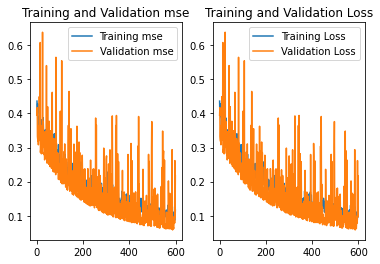

MSE on testset:0.22080279886722565


In [26]:
#Use MobileNet-v2 without finetuning
x_train, y_train, x_val, y_val, x_test, y_test = prePrec(data_x, data_y,gray=True)
base_model = tf.keras.applications.MobileNetV2(input_shape=commom_size,include_top=False,weights='imagenet')
#Freeze the model.
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalMaxPooling2D()
conv_layer = tf.keras.layers.Conv2D(10,(3,3),activation='relu',padding='same')
prediction_layer = tf.keras.layers.Dense(1,activation='tanh')
    
inputs = tf.keras.Input(shape=commom_size)
x = base_model(inputs)
x = conv_layer(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
    
train(model,x_train,y_train,x_val,y_val,parameters=parameter_set['mobilenet-v2_regression'])
mse = tf.keras.losses.MeanSquaredError()
loss = mse((y_test-15)/15.,model.predict(x_test).reshape(-1,))
print('MSE on testset:{}'.format(loss))

## Task4: Adapt MobileNet V2 and finetuning
### This task uses a non-sequential model with parallel images input in two pretrained MobileNet-V2 models and than stack the output feature maps. This task has two steps. First, freeze the model and train for 20 epoch. Then I unfreeze 56 layers in MobileNet-V2 and take another 40 epoch to finetune it. 
* The trainable parameters is much more than previous cases, so it takes more times to train.
* MSE on training set, validation set and testing set are all approximately 0.003

Pre-precessing....
Training....
Epoch 1/20
175/175 [==============================] - 10s 55ms/step - loss: 0.1753 - mse: 0.1753 - val_loss: 0.0702 - val_mse: 0.0702
Epoch 2/20
175/175 [==============================] - 8s 45ms/step - loss: 0.0481 - mse: 0.0481 - val_loss: 0.0932 - val_mse: 0.0932
Epoch 3/20
175/175 [==============================] - 8s 47ms/step - loss: 0.0403 - mse: 0.0403 - val_loss: 0.0390 - val_mse: 0.0390
Epoch 4/20
175/175 [==============================] - 8s 47ms/step - loss: 0.0283 - mse: 0.0283 - val_loss: 0.0251 - val_mse: 0.0251
Epoch 5/20
175/175 [==============================] - 8s 45ms/step - loss: 0.0211 - mse: 0.0211 - val_loss: 0.0304 - val_mse: 0.0304
Epoch 6/20
175/175 [==============================] - 8s 47ms/step - loss: 0.0187 - mse: 0.0187 - val_loss: 0.0162 - val_mse: 0.0162
Epoch 7/20
175/175 [==============================] - 8s 44ms/step - loss: 0.0165 - mse: 0.0165 - val_loss: 0.0225 - val_mse: 0.0225
Epoch 8/20
175/175 [================

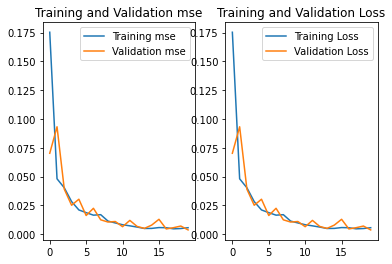

Training....
Epoch 20/60
175/175 [==============================] - 14s 80ms/step - loss: 0.0944 - mse: 0.0944 - val_loss: 0.0913 - val_mse: 0.0913
Epoch 21/60
175/175 [==============================] - 13s 72ms/step - loss: 0.0330 - mse: 0.0330 - val_loss: 0.0608 - val_mse: 0.0608
Epoch 22/60
175/175 [==============================] - 13s 72ms/step - loss: 0.0229 - mse: 0.0229 - val_loss: 0.0207 - val_mse: 0.0207
Epoch 23/60
175/175 [==============================] - 13s 72ms/step - loss: 0.0153 - mse: 0.0153 - val_loss: 0.0152 - val_mse: 0.0152
Epoch 24/60
175/175 [==============================] - 13s 73ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 25/60
175/175 [==============================] - 13s 73ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 26/60
175/175 [==============================] - 13s 73ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 27/60
175/175 [=====================

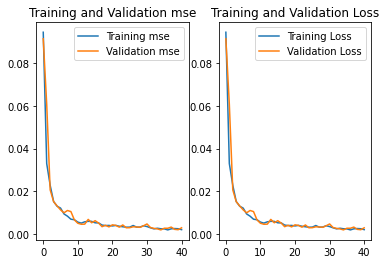

MSE on testset:0.0035999855026602745


In [10]:
#Use MobileNet-v2 with parallel input
x_train, y_train, x_val, y_val, x_test, y_test = prePrec(data_x, data_y,parallel=True)
base_model = tf.keras.applications.MobileNetV2(input_shape=commom_size,
                                                   include_top=False,
                                                   weights='imagenet')
base_model.trainable = False
    
global_average_layer = tf.keras.layers.GlobalMaxPooling2D()
conv_layer = tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')
d1=tf.keras.layers.Dense(120,activation='relu')
d2=tf.keras.layers.Dense(84,activation='relu')
prediction_layer = tf.keras.layers.Dense(1,activation='tanh')
    
#Parallel input
inputs1 = tf.keras.Input(shape=commom_size)
inputs2 = tf.keras.Input(shape=commom_size)
x1 = base_model(inputs1)
x1 = tf.keras.Model(inputs1,x1)
x2 = base_model(inputs2)
x2 = tf.keras.Model(inputs2,x2)
#Concatenate two feature maps
combine=K.concatenate([x1.output , x2.output])
combine=conv_layer(combine)
y=global_average_layer(combine)
y=d1(y)
y=d2(y)
outputs = prediction_layer(y)
    
model_mob = tf.keras.Model([x1.input,x2.input], outputs)
#Train first 20 epoch without finetuning
model_mob=train(model_mob,x_train,y_train,x_val,y_val,parameters=parameter_set['mobilenet-v2_parallel'])

#unfreeze the pretrained network
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model_mob=train(model_mob[0],x_train,y_train,x_val,y_val,parameters=parameter_set['momobilenet-v2_finetune'],continue_from=model_mob[1].epoch[-1])
mse = tf.keras.losses.MeanSquaredError()
loss = mse((y_test-15)/15.,model_mob[0].predict([x_test[0],x_test[1]]).reshape(-1,))
print('MSE on testset:{}'.format(loss))